# Demo a Single Simulation Run

In this notebook, we demonstrate a single run of our risk simulation:
- We show the logs of agent actions (e.g. liquidations, arbitrages, peg keeper updates).
- We show a timeseries view of the metrics we collect on agents and the crvusd contracts.
- We plot and analyze results

### Some current limitations
- We are only modeling a single LLAMMA. We are working to incorporate all LLAMMAs to consider hollistic systemic risk.
- We are not considering some key Curve pools yet. For example, we are not explicitly modeling the TriCrypto-ng pools that feed into LLAMMA's oracle.

In [1]:
import pandas as pd

from src.logging import get_logger

logger = get_logger(__name__, "debug")

from src.sim.scenario import Scenario
from src.sim.processing import SingleSimProcessor
from src.metrics import DEFAULT_METRICS

pd.set_option("display.max_columns", None)
%load_ext autoreload
%autoreload 2

In [2]:
# Generate markets and prices
market_name = "wstETH"
scenario = Scenario("baseline", market_name)
scenario.prepare_for_run()
print(
    f"Running {scenario.num_steps} steps with frequency {scenario.pricepaths.config['freq']}."
)

[INFO][15:42:36][src.sim.scenario]-31818: Fetching sim_market from subgraph.
[INFO][15:42:48][src.utils.poolgraph]-31818: Found 20 valid trading cycles of length 3.


Running 168 steps with frequency 1h.


In [3]:
processor = SingleSimProcessor(scenario, DEFAULT_METRICS)
processor.initial_state

{'timestamp': Timestamp('2023-12-21 18:42:43'),
 'arbitrageur_profit': 0,
 'arbitrageur_volume': 0,
 'arbitrageur_count': 0,
 'liquidator_profit': 0.0,
 'liquidator_volume': 0,
 'liquidator_count': 0,
 'keeper_profit': 0.0,
 'keeper_volume': 0,
 'keeper_count': 0,
 'borrower_profit': 0.0,
 'borrower_volume': 0,
 'borrower_count': 0,
 'liquidityprovider_profit': 0.0,
 'liquidityprovider_volume': 0,
 'liquidityprovider_count': 0,
 'aggregator_price': 0.9993138889328522,
 'controller_wstETH_system_health': 0.6026489060309543,
 'controller_wstETH_bad_debt': 5496105.732223177,
 'controller_wstETH_num_loans': 322,
 'controller_wstETH_total_debt': 35493152.311266966,
 'controller_wstETH_users_to_liquidate': 1,
 'llamma_wstETH_price': 2383.4060728736536,
 'llamma_wstETH_oracle_price': 2565.1994913230574,
 'llamma_wstETH_fees_x': 0,
 'llamma_wstETH_fees_y': 0,
 'llamma_wstETH_bal_x': 885272.9237758956,
 'llamma_wstETH_bal_y': 23497.184574760166,
 'pk_crvUSD/TUSD_debt': 73333.40537847174,
 'pk_c

Text(0.5, 1.0, 'wstETH Loan Distribution')

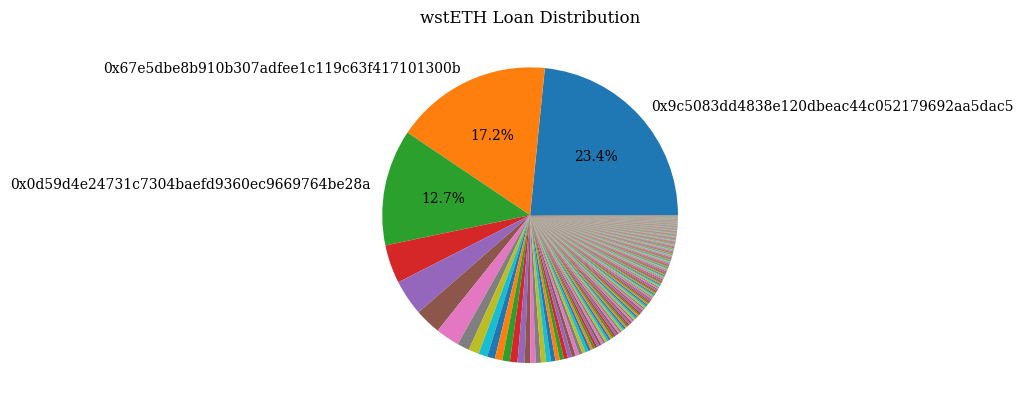

In [4]:
import matplotlib.pyplot as plt


def custom_autopct(pct):
    return "{:.1f}%".format(pct) if pct > 5 else ""


controller = scenario.controller
total_debt = 0
loans = {}
for user, loan in controller.loan.items():
    debt = loan.initial_debt / 1e18
    loans[user] = debt
    total_debt += debt

thresh = 0.05 * total_debt
loans = dict(sorted(loans.items(), key=lambda x: x[1], reverse=True))
labels = [a if loans[a] > thresh else "" for a in loans.keys()]
f, ax = plt.subplots()
pie = ax.pie(loans.values(), labels=labels, autopct=custom_autopct)
ax.set_title(f"{scenario.market_name} Loan Distribution")

### Run the Sim

In [5]:
for sample in scenario.pricepaths:
    scenario.prepare_for_trades(sample)  # update prices/timestamps
    scenario.perform_actions(sample)  # arbitrage, liquidate, update
    processor.update(sample.timestamp, inplace=True)  # collect metrics

In [6]:
results = processor.process()

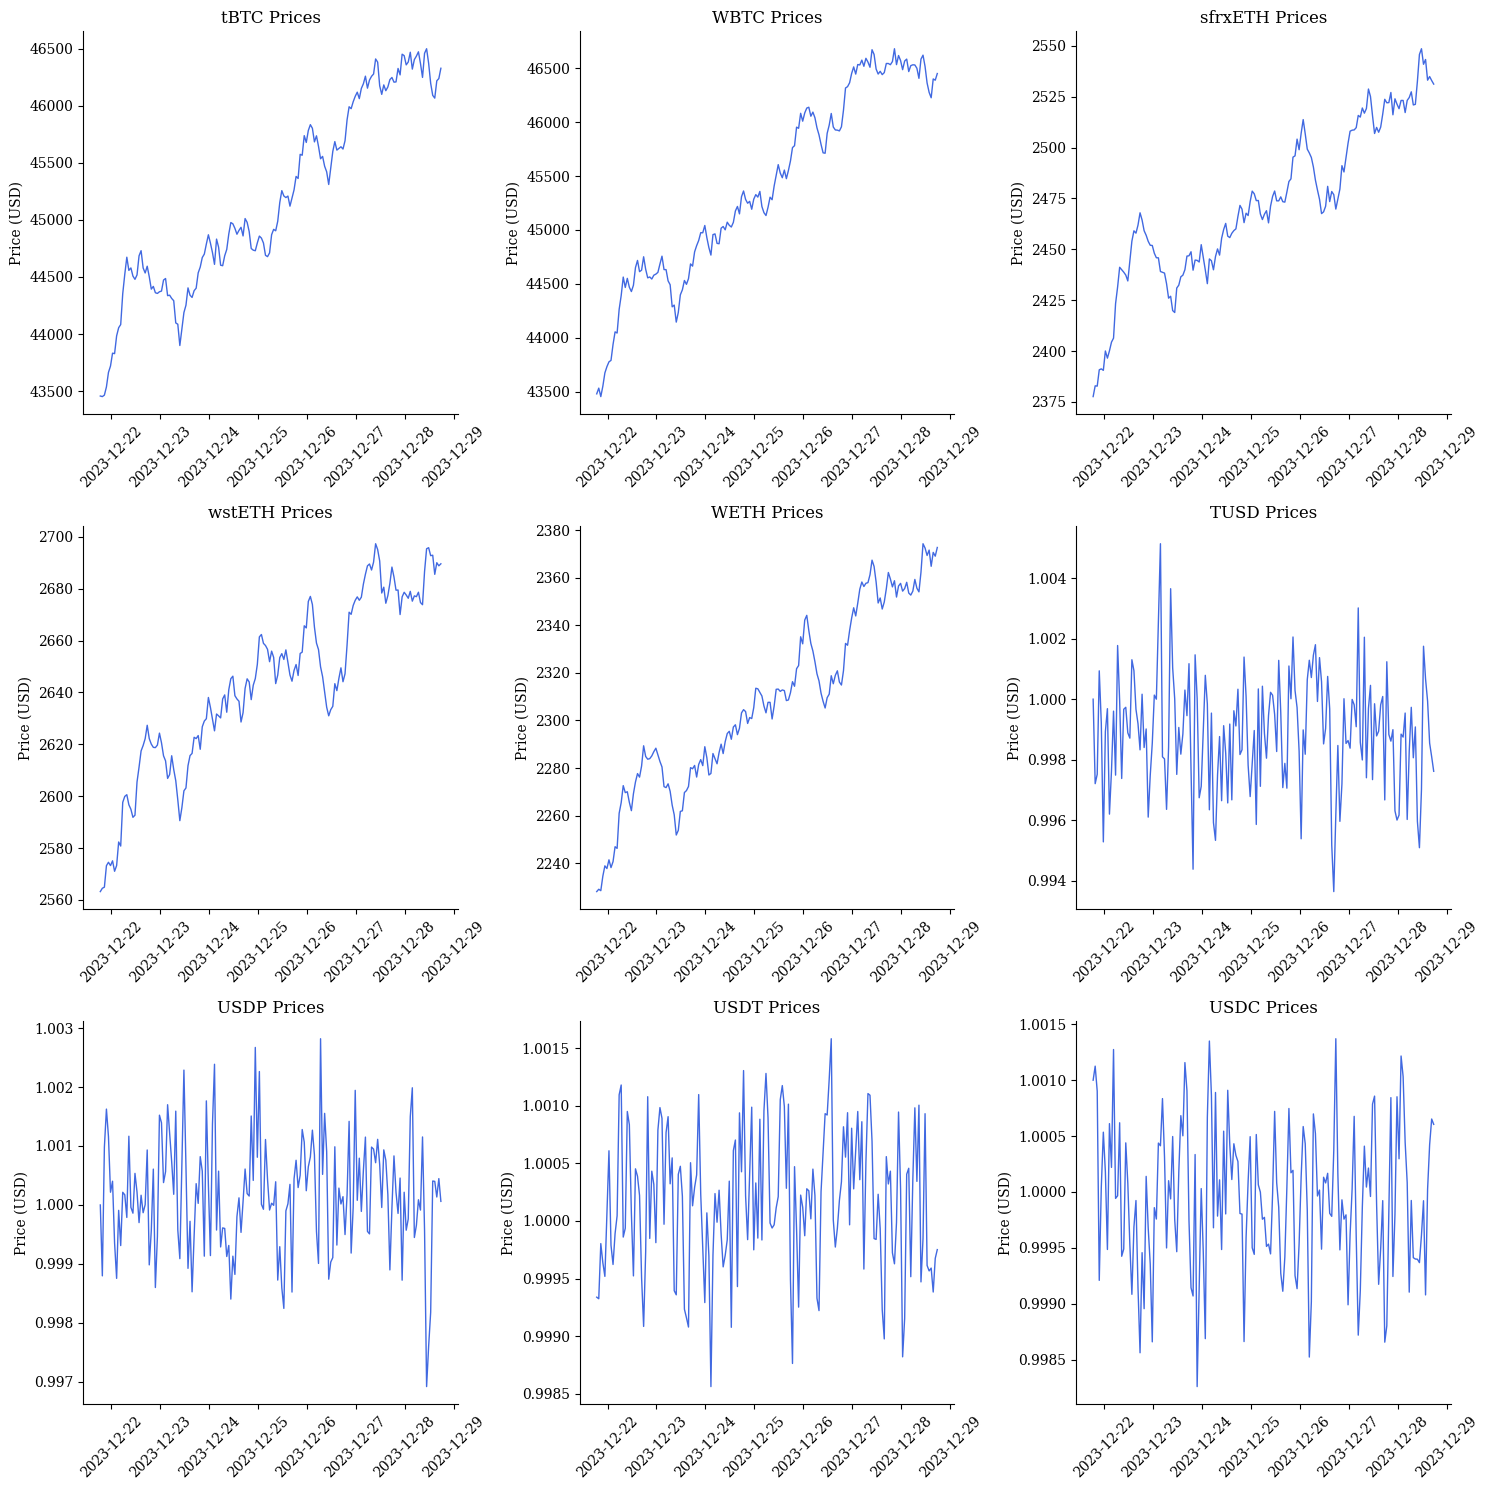

In [7]:
results.plot_prices()

In [8]:
df = results.df
df.to_csv("../data/results.csv")
df.tail()

,arbitrageur_profit,arbitrageur_volume,arbitrageur_count,liquidator_profit,liquidator_volume,liquidator_count,keeper_profit,keeper_volume,keeper_count,borrower_profit,borrower_volume,borrower_count,liquidityprovider_profit,liquidityprovider_volume,liquidityprovider_count,aggregator_price,controller_wstETH_system_health,controller_wstETH_bad_debt,controller_wstETH_num_loans,controller_wstETH_total_debt,controller_wstETH_users_to_liquidate,llamma_wstETH_price,llamma_wstETH_oracle_price,llamma_wstETH_fees_x,llamma_wstETH_fees_y,llamma_wstETH_bal_x,llamma_wstETH_bal_y,pk_crvUSD/TUSD_debt,pk_crvUSD/TUSD_profit,pk_crvUSD/USDP_debt,pk_crvUSD/USDP_profit,pk_crvUSD/USDC_debt,pk_crvUSD/USDC_profit,pk_crvUSD/USDT_debt,pk_crvUSD/USDT_profit,stablecoin_total_supply,stableswap_crvUSD_TUSD_price,stableswap_crvUSD_TUSD_ma_price,stableswap_crvUSD_TUSD_lp_supply,stableswap_crvUSD_TUSD_virtual_price,stableswap_crvUSD_TUSD_TUSD_bal,stableswap_crvUSD_TUSD_crvUSD_bal,stableswap_crvUSD_USDP_price,stableswap_crvUSD_USDP_ma_price,stableswap_crvUSD_USDP_lp_supply,stableswap_crvUSD_USDP_virtual_price,stableswap_crvUSD_USDP_USDP_bal,stableswap_crvUSD_USDP_crvUSD_bal,stableswap_crvUSD_USDC_price,stableswap_crvUSD_USDC_ma_price,stableswap_crvUSD_USDC_lp_supply,stableswap_crvUSD_USDC_virtual_price,stableswap_crvUSD_USDC_USDC_bal,stableswap_crvUSD_USDC_crvUSD_bal,stableswap_crvUSD_USDT_price,stableswap_crvUSD_USDT_ma_price,stableswap_crvUSD_USDT_lp_supply,stableswap_crvUSD_USDT_virtual_price,stableswap_crvUSD_USDT_USDT_bal,stableswap_crvUSD_USDT_crvUSD_bal
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-12-28 13:42:43,160021.752535,0,447,19582.224128,0,9,0.0,0,0,0.0,0,0,0.0,0,0,0.999383,0.684048,5.188833e+06,313,3.527738e+07,1,2711.947068,2692.882555,5502,0,698995.935934,23389.273668,73333.405378,0,0.0,0,0.0,0,0.0,0,4.317654e+08,0.998040,0.998055,4.477169e+06,1.000790,1.416353e+06,3.065052e+06,0.998943,0.999151,4.142005e+06,1.000389,1.582332e+06,2.561529e+06,0.999570,0.999547,3.554462e+07,1.000212,0.000016,1.965044e+07,0.999263,0.999260,2.735668e+07,1.000245,0.000011,1.606026e+07
2023-12-28 14:42:43,160167.148920,0,450,19582.224128,0,9,0.0,0,0,0.0,0,0,0.0,0,0,0.999385,0.679306,5.188833e+06,313,3.527802e+07,1,2689.747298,2685.509800,5502,0,698995.935934,23389.273668,73333.405378,0,0.0,0,0.0,0,0.0,0,4.325242e+08,0.998479,0.998362,4.477169e+06,1.000791,1.543157e+06,2.938035e+06,0.998843,0.998848,4.142005e+06,1.000389,1.545958e+06,2.597945e+06,0.999392,0.999417,3.554462e+07,1.000213,0.000015,2.037288e+07,0.999474,0.999474,2.735668e+07,1.000246,0.000012,1.542839e+07
2023-12-28 15:42:43,160767.812656,0,454,19582.224128,0,9,0.0,0,0,0.0,0,0,0.0,0,0,0.999434,0.682146,5.188833e+06,313,3.527865e+07,1,2703.109662,2690.003815,5502,0,698995.935934,23389.273668,73333.405378,0,0.0,0,0.0,0,0.0,0,4.339054e+08,0.999888,0.999555,4.477169e+06,1.000799,2.177889e+06,2.302859e+06,0.998843,0.998843,4.142005e+06,1.000389,1.545958e+06,2.597945e+06,0.999011,0.999273,3.554462e+07,1.000215,0.000014,2.175402e+07,0.999705,0.999701,2.735668e+07,1.000247,0.000013,1.468236e+07
2023-12-28 16:42:43,160825.311692,0,457,19582.224128,0,9,0.0,0,0,0.0,0,0,0.0,0,0,0.999286,0.681351,5.188833e+06,313,3.527927e+07,1,2699.425655,2688.807036,5502,0,698995.935934,23389.273668,73333.405378,0,0.0,0,0.0,0,0.0,0,4.342300e+08,1.000480,1.000220,4.477169e+06,1.000802,2.502633e+06,1.978189e+06,0.998843,0.998843,4.142005e+06,1.000389,1.545958e+06,2.597945e+06,0.998911,0.998958,3.554462e+07,1.000215,0.000013,2.207867e+07,0.999705,0.999705,2.735668e+07,1.000247,0.000013,1.468236e+07
2023-12-28 17:42:43,160863.428347,0,459,19582.224128,0,9,0.0,0,0,0.0,0,0,0.0,0,0,0.999239,0.681810,5.188833e+06,313,3.527990e+07,1,2701.630755,2689.574535,5502,0,698995.935934,23389.273668,73333.405378,0,0.0,0,0.0,0,0.0,0,4.344069e+08,1.000846,1.000654,4.477169e+06,1.000804,2.679669e+06,1.801278e+06,0.998843,0.998843,4.142005e+06,1.000389,1.545958e+06,2.597945e+06,0.998855,0.998884,3.554462e+07,1.000216,0.000013

In [9]:
results.metric_map

{'AgentMetrics': 0,
 'AggregatorMetrics': 1,
 'ControllerMetrics': 2,
 'LLAMMAMetrics': 3,
 'PegKeeperMetrics': 4,
 'StablecoinMetrics': 5,
 'StableSwapMetrics': 6}

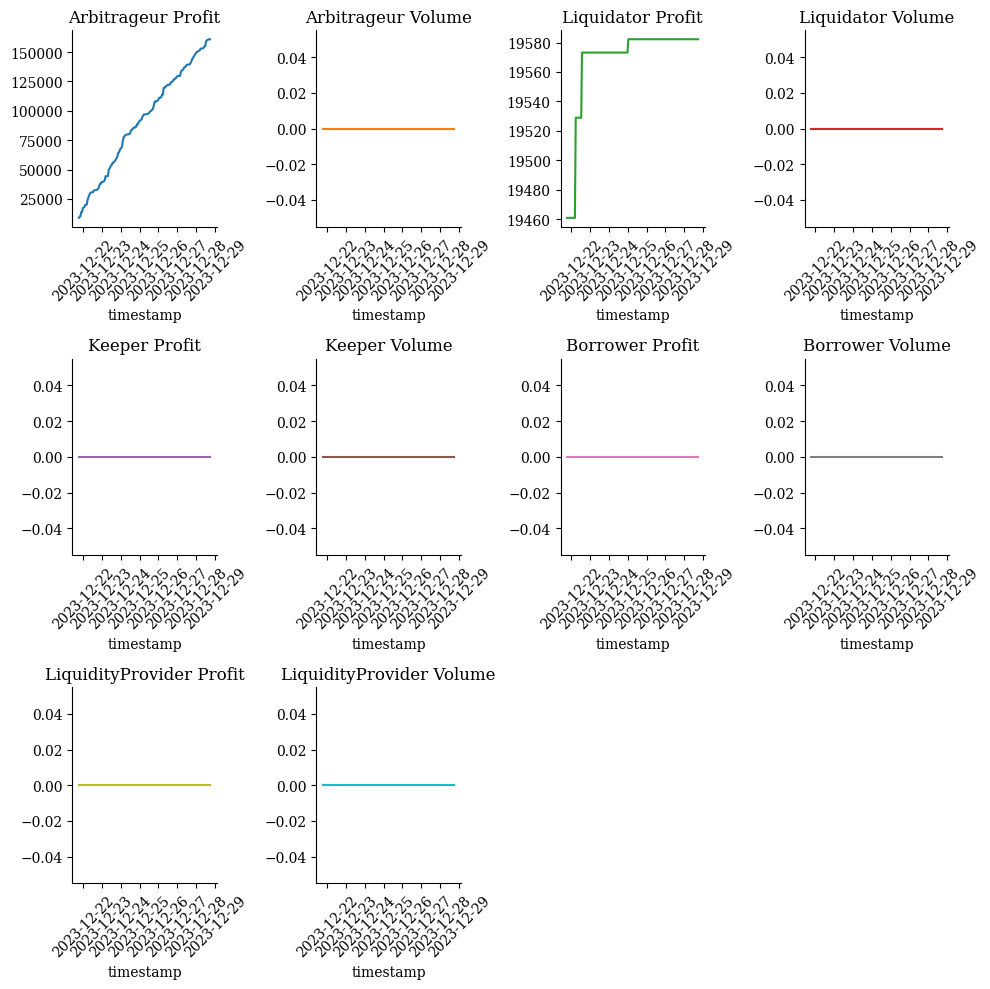

In [10]:
results.plot_metric(0, show=True)

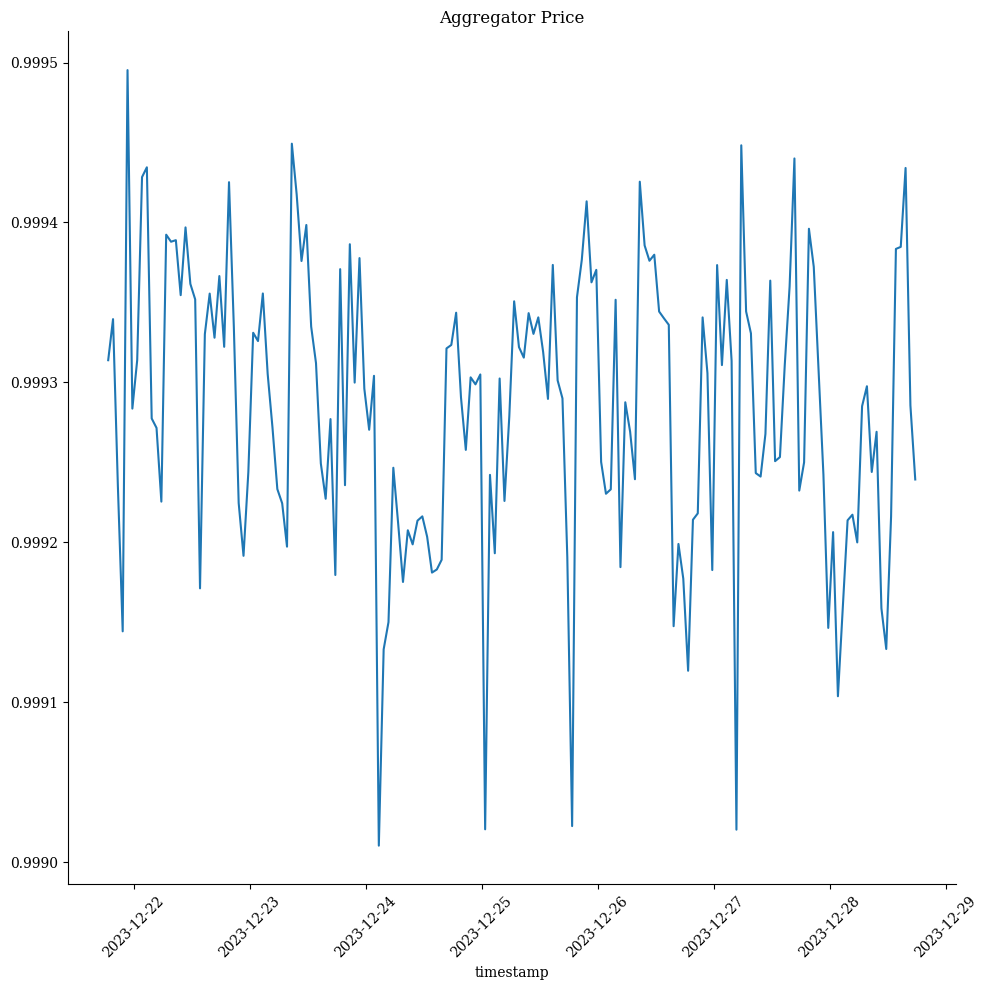

In [11]:
results.plot_metric(1, show=True)

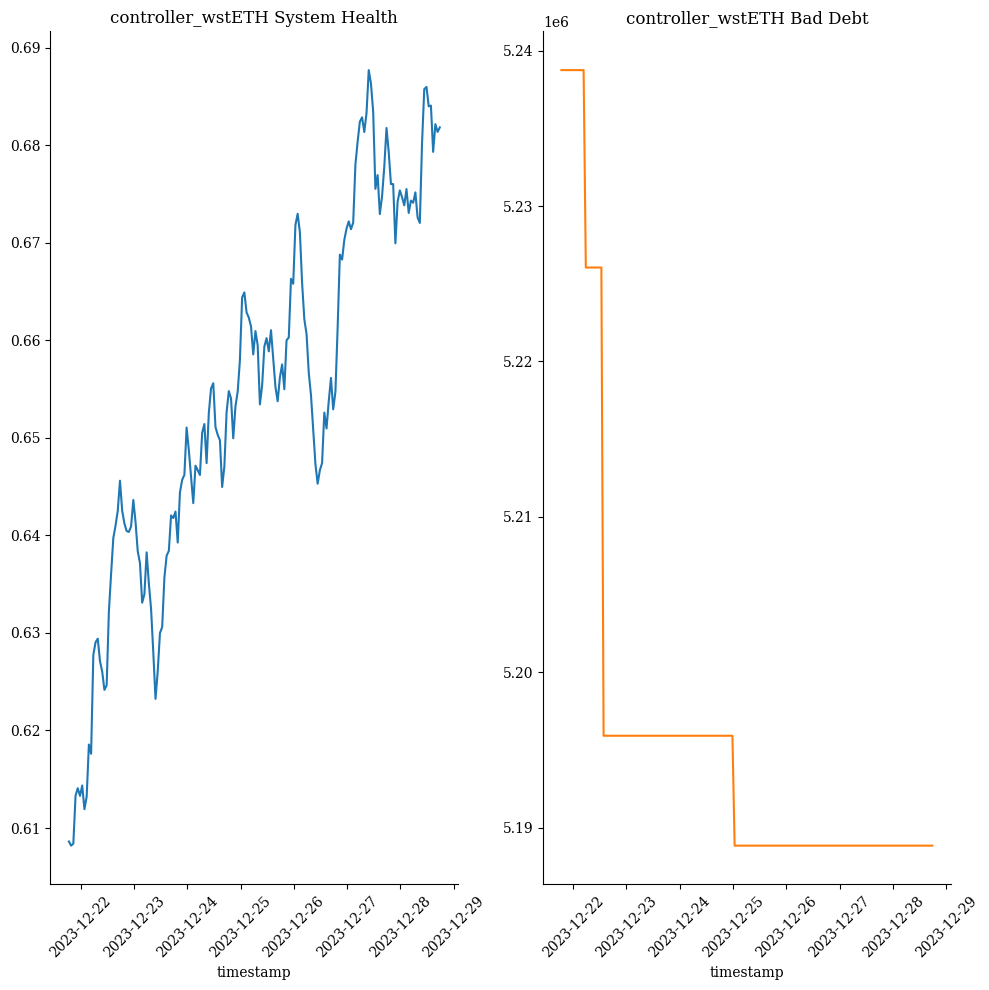

In [12]:
results.plot_metric(2, show=True)

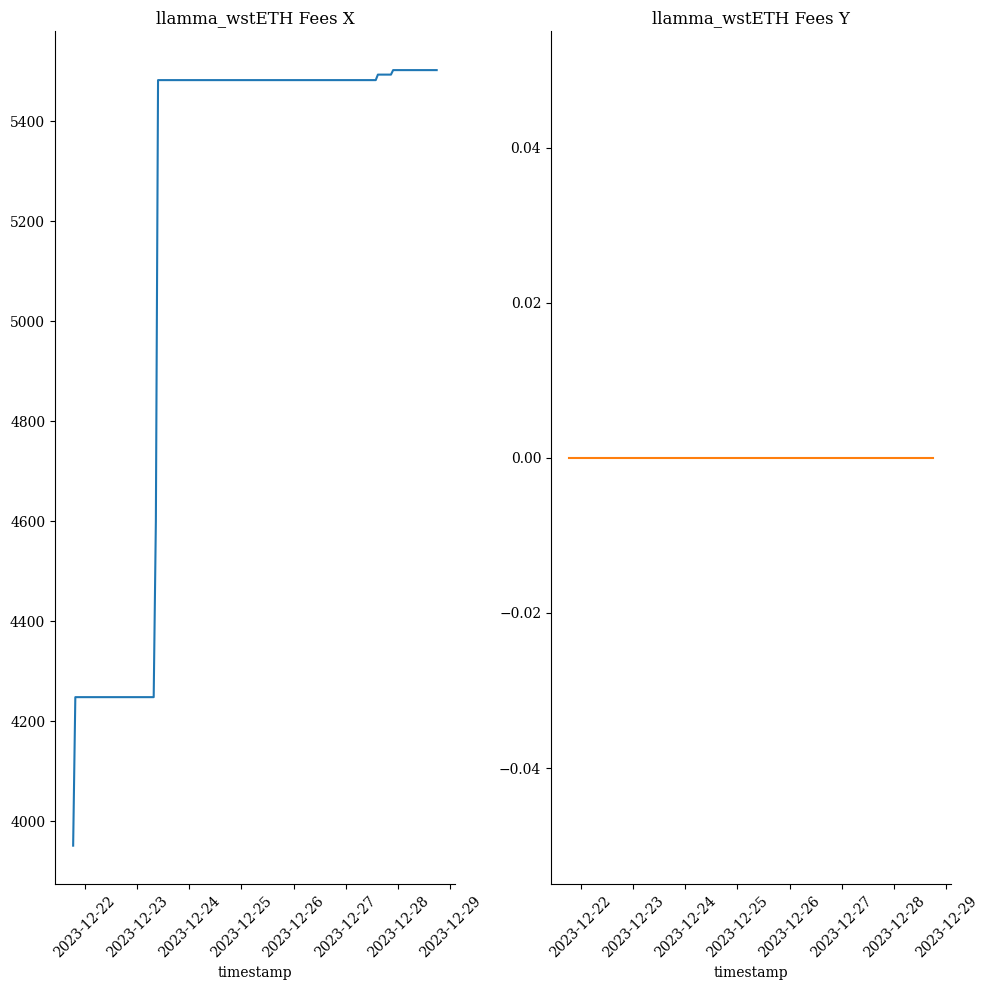

In [13]:
results.plot_metric(3, show=True)  # seems broken from crvusdsim

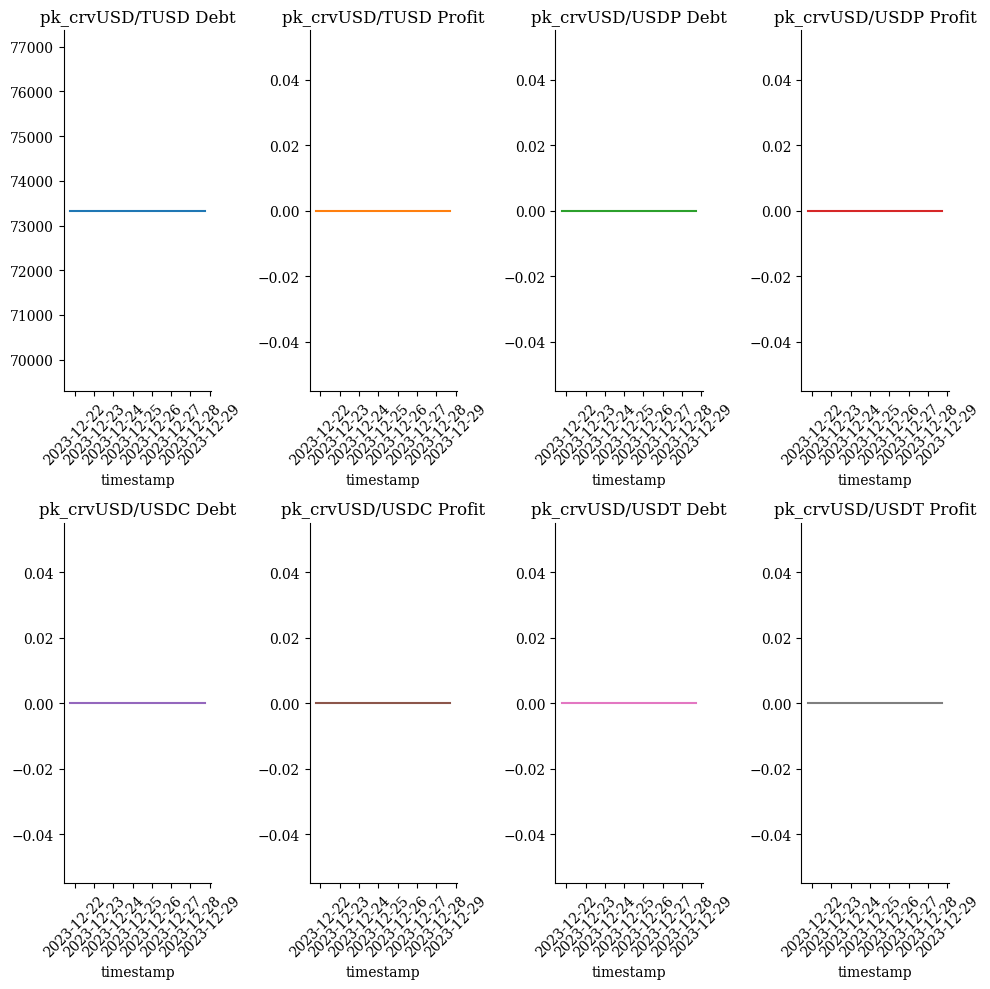

In [14]:
results.plot_metric(4, show=True)

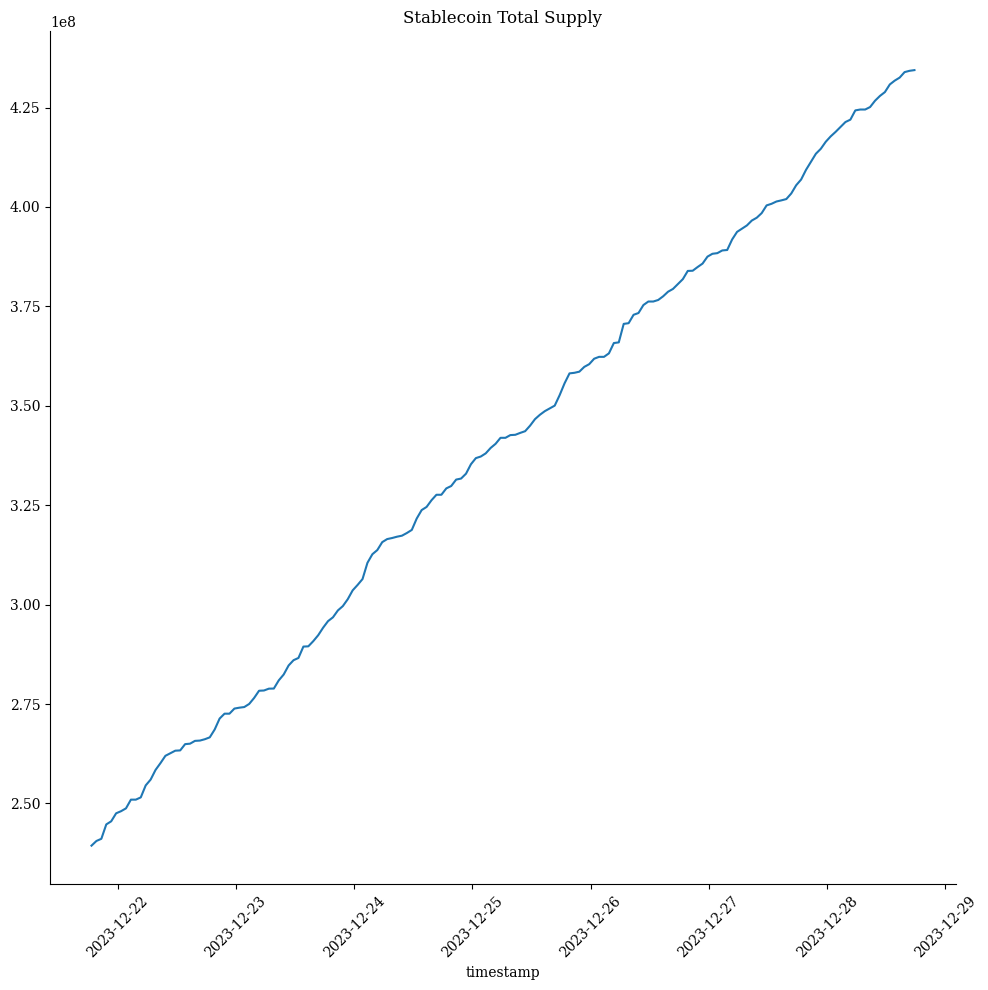

In [15]:
results.plot_metric(5, show=True)

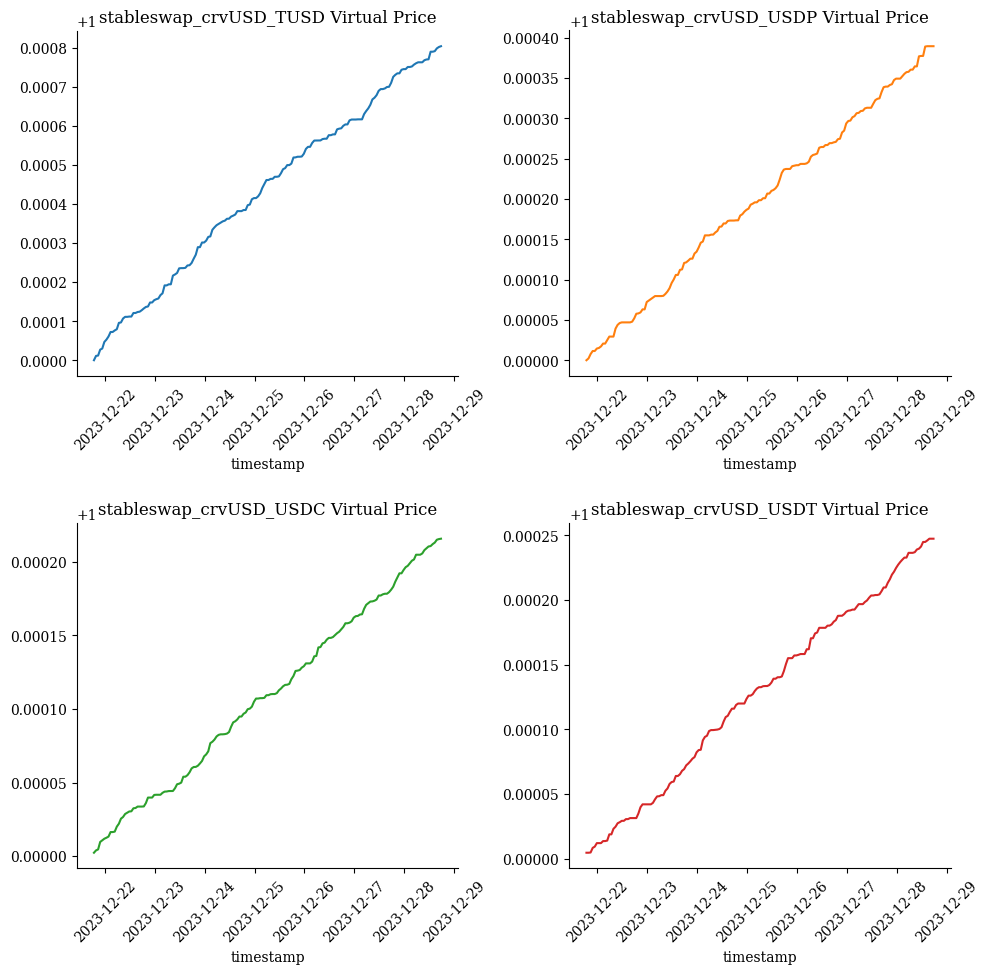

In [16]:
results.plot_metric(6, show=True)

In [17]:
summary = results.summarize().T
summary.columns = ["value"]
summary

,value
arbitrageur_profit_max,1.608634e+05
arbitrageur_volume_max,0.000000e+00
liquidator_profit_max,1.958222e+04
liquidator_volume_max,0.000000e+00
keeper_profit_max,0.000000e+00
keeper_volume_max,0.000000e+00
borrower_profit_max,0.000000e+00
borrower_volume_max,0.000000e+00
liquidityprovider_profit_max,0.000000e+00
liquidityprovider_volume_max,0.000000e+00
